# 1.0 Imports

In [266]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from boruta import BorutaPy
import pickle
import pandas.api.types as pat

# 2.0 Read CSV
**Nesta etapa, o arquivo csv é lido e atribuido à classe pandas. Também utilizo a função head() para me ajudar a enxergar como os dados estão dispostos, com isso posso gerar ideias de como fazer a próxima etapa.**

In [267]:
dir_path = os.path.dirname(os.path.abspath(''))
csv_path = os.path.join(dir_path,'dataset','teste_indicium_precificacao.csv')
data_frame = pd.read_csv(csv_path)
data_frame.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# 3.0 Functions
**Todas as funções definidas estão nesta parte do notebook. Assim como suas documentações.**

In [268]:
def outliers_identification(df, coluna, remover=False):
    """
        função que identifica outliers. 
        args:
            df (Pandas.DataFrame) : data frame contendo a coluna a qual será executada o cálculo de outliers.
            coluna (string): nome da coluna numérica que será operada.
            remover (bool ; default False): determina se removerá as linas com outliers ou não.
        retorno:
            remover == False:
                (Pandas.DataFrame): retorna um dataframe com duas colunas, uma contendo os outliers inferiores e 
                a outra os inferiores.
            remover == True:
                (Pandas.DataFrame): retorna o df filtrando as linhas de outliers.
    """
    quartil_1 = df[coluna].quantile(0.25)
    quartil_3 = df[coluna].quantile(0.75)
    intervalo_interquartil = quartil_3 - quartil_1
    limite_superior = quartil_3 + 1.5*intervalo_interquartil
    limite_inferior = quartil_1 - 1.5*intervalo_interquartil
    if remover == True:
        df_filtrado = df[(df[coluna]<limite_superior) & (df[coluna]>limite_inferior)]
        return df_filtrado  
        
    outliers = pd.DataFrame(columns=['inferior_outliers','superior_outliers'])
    outliers['inferior_outliers'] = df[df[coluna] < limite_inferior][coluna]
    outliers['superior_outliers'] = df[df[coluna] > limite_superior][coluna]
    return outliers

def plot_bar_specific(series, xlabel, ylabel, title, **kwargs):
    """
        função que plota um gráfico de barra com características específicas como,
        tamanho da figura, cor de background, grid e rotação dos labels do eixo X.
        args:
            series (Pandas.Series): panda series de onde será tirado as categorias e seus valores, 
            xlabel (string): o nome do eixo X
            ylabel (string): o nome do eixo y
            title (string): título do gráfico 
            **kwargs {
                values (numpy.ndarray): contém valores que não estão presentes na 'series',
                categorias (numpy.ndarray): contém categorias que não estão presentes na 'series'
            }
    """
    if 'values' in kwargs:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = series.index
        valores = kwargs['values']
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=25)
        plt.show()
    elif 'categorias' in kwargs:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = kwargs['categorias']
        valores = series.values
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, fontsize=8)
        plt.show()
    else:
        plt.figure(figsize=(8, 3.5), facecolor='lightgrey')
        indices = series.index
        valores = series.values
        plt.bar(indices, valores, zorder=3, color='purple')
        plt.grid(linestyle='-', zorder=0, alpha=1, color='skyblue')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=25)
        plt.show()

def is_leap_year(year):
    """
        função que para calcular ano bissexto. 
        args:
            year (int): ano a ser analisado
        retorno:
            (bool): True caso o parâmetro seja um ano bissexto e False caso contrário.
    """
    if year%4 != 0:
        return False
    elif year%100 == 0 and year%400 != 0:
        return False
    else:
        return True

def categories_appender(series):
    """
        função que a partir de um Pandas series extrai os index de um MultiIndex e 
        os anexa separando-os por um '-'. 
        *OBS: Essa função é utilizada para os casos de series.index sendo um MultiIndex de 2 índices.*
        args:
            series (Pandas.Series): Pandas series de onde são extraidos os index.
        retorno:
            (numpy.ndarray): array contendo as categorias anexadas por um '-'.
    """
    list_aux = []
    for i in range(len(series.index)):
        string_aux0 = str(series.index[i][0])
        string_aux1 = str(series.index[i][1])
        list_aux.append(string_aux0+'-'+string_aux1)
    aux = np.array(list_aux)
    return aux

def data_processing(df):
    """
        função que prepara a base de dados para a análise. Sua função é padronizar e renomear colunas,
         remover valores vazios do dataset, transformação de dados e criação de outras colunas que auxiliam
         na análise dos dados.
         args:
             df (Pandas.DataFrame): data frame ao qual será realizado todo o processamento de dados.
         retorno:
             (Pandas.DataFrame): data frame após as alterações
    """
    # padronização dos nomes das colunas
    # criação de um dict com a troca de nomes das colunas
    colunas_renomeadas = {'nome':'name',
                          'bairro_group':'district',
                          'bairro':'neighborhood',
                          'minimo_noites':'minimum_nights',
                          'numero_de_reviews':'reviews_count',
                          'ultima_review':'last_review',
                          'reviews_por_mes':'monthly_reviews',
                          'calculado_host_listings_count':'calculated_host_listings_count',
                          'disponibilidade_365':'yearly_availability'}
    
    df.rename(columns=colunas_renomeadas, inplace=True)
    
    # eliminação de valores vazios das colunas identificadas
    for coluna in ['name', 'host_name', 'last_review', 'monthly_reviews']:
        df.dropna(subset=[coluna], inplace=True)
    
    # transformar coluna last_review em date time
    df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')
    
    # criação de uma coluna chamada total_price que é o price multiplicado pela quantidade mínima de noites
    df['total_price'] = df.apply(lambda row: row['price']*row['minimum_nights'], axis=1)
    
    # criação da coluna year contendo somente o ano da coluna last_review
    df['year'] = df['last_review'].dt.year
    df['year'] = np.int64(df['year'])
    
    # criação da coluna is_leap_year para checar se o ano é bissexto ou não
    df['is_leap_year'] = df['year'].apply(is_leap_year)
    
    # criação da coluna days booked_days informando quantos dias já foram agendados naquele ano
    df['booked_days'] = df.apply(
                            lambda row: 366 - row['yearly_availability'] if is_leap_year(row['year']) else 365 - row['yearly_availability'],
                            axis = 1
                        )
    return df

def boruta_columns_selection(X_values, y_values, path):
    """
        função que tem como objetivo utilizar os valores de X e y para treinar o boruta
        com o intuito de apontar colunas relevantes. Além de salvar esse processo em um
        arquivo .pkl.
        args:
            X_values (numpy.ndarray): array contendo os valores numéricos de X
            y_values (numpy.ndarray): array contendo os valores numéricos de y
    """
    random_forest = RandomForestClassifier(n_jobs=-1, max_depth=5)

    boruta = BorutaPy(random_forest, n_estimators='auto', random_state=26)
    
    boruta.fit(X_values, y_values)
    
    with open(path, 'wb') as f:
        pickle.dump(boruta, f)

def mape(y_real, y_pred):
    """
        função que calcula o Erro Percentual Absoluto Médio (MAPE)
        args:
            y_real (pd.Series): Valores reais.
            y_pred (pd.Series): Valores previstos.
        retorno:
            float: valor do MAPE em percentual.
    """
    valor_diferente_zero = y_real != 0
    y_real, y_pred = y_real[valor_diferente_zero], y_pred[valor_diferente_zero]
    erro_absoluto = np.abs((y_real-y_pred)/y_real)
    mape = np.mean(erro_absoluto)*100
    return mape

def metrics(y_teste, y_pred, y_treino, X_treino):
    """
        essa função tem como objetivo o cálculo das métricas de avaliação e suas visualizações.
        args:
            y_teste (Panda.Series): series contendo os valores reais a serem previstos.
            y_pred (numpy.ndarray): array contendo os valores preditos pelo modelo.
            y_treino (Panda.Series): series contendo os valores reais que foram usados como base de treino.
            X_treino (numpy.ndarray): array contendo os valores reais 
            
    """
    erro_medio_absoluto = mean_absolute_error(y_teste, y_pred)
    print(f'MAE: {erro_medio_absoluto}')
    
    erro_quadratico = mean_squared_error(y_teste, y_pred)
    sqrt_erro_quadratico = erro_quadratico ** 0.5
    print(f'RMSE: {sqrt_erro_quadratico}')
    
    coeficiente_de_determinacao = r2_score(y_teste, y_pred)
    print(f'R²: {coeficiente_de_determinacao}')
    
    # Calculo de R² na base de treino para checar Outfitting
    r2_treino = r2_score(y_treino, modelo.predict(X_treino))
    print(f'R² treino: {r2_treino}')
    
    erro_absoluto_medio = mape(y_teste, y_pred)
    print(f'MAPE: {erro_absoluto_medio:.2f}%')

def pre_processing_prediction(X, sem_outliers=False):
    """
        função que processa os dados de um data frame antes do processo de predição.
        args:
            X (Pandas.DataFrame) : data frame ao qual será submetido o processamento
            sem_outliers (bool;default=False) : variável booleana que remove ou não os outliers
            de colunas específicas.
        retorno: 
            sem_outliers == True:
                (Pandas.DataFrame) : data frame pré processado removendo os outliers.
            sem_outliers == False:
                (Pandas.DataFrame) : data frame pré processado.
    """
    # encoder para transformação dos dados não numéricos
    encoder = LabelEncoder()
    if sem_outliers == True:
        colunas_para_nao_excluir = ['price', 'id', 'host_id', 'latitude', 'longitude', 'yearly_availability', 'booked_days', 'year']
        aux = X[X.columns.difference(colunas_para_nao_excluir)]
        for coluna in aux.columns:
            if pat.is_numeric_dtype(X[coluna]) and not pat.is_bool_dtype(X[coluna]):
                X = outliers_identification(X, coluna, remover=True)
        
        # carregamento do arquivo boruta do modelo sem outliers, contendo informações das colunas mais relevantes
        dir_path = os.path.dirname(os.path.abspath(''))
        pickle_path = os.path.join(dir_path,'Pickle','modelo_boruta_sem_outliers.pkl')
       
        #boruta_columns_selection(X_sem_price.values, X['price'].values, pickle_path)
        with open(pickle_path, 'rb') as f:
            carregar_boruta = pickle.load(f)

        # boruta precisa do dataframe sem a coluna de price para que a predição não fique enviesada
        X_sem_price = X.loc[:, X.columns != 'price']
        s = X['price']
        X = X_sem_price.iloc[:, carregar_boruta.support_]

        # porém o retorno necessita do price para atribuir ao y
        X['price'] = s
        return X
    else:
        # carregamento do arquivo boruta, contendo informações das colunas mais relevantes
        dir_path = os.path.dirname(os.path.abspath(''))
        pickle_path = os.path.join(dir_path,'Pickle','modelo_boruta.pkl')
        with open(pickle_path, 'rb') as f:
            carregar_boruta = pickle.load(f)

    # seleção das colunas importantes,
    df_colunas_importantes = X.iloc[:, carregar_boruta.support_]
    
    # aplicando o robust scaler no data frame com as colunas selecionadas
    #scaler = RobustScaler()
    #df_scaled = scaler.fit_transform(df_colunas_importantes)
    return df_colunas_importantes

def encoding(X):
    """
        função que codifica colunas não númericas em números.
        args:
            X (Pandas.DataFrame) : data frame com as colunas ainda não codificadas.
        retorno:
            (Pandas.DataFrame) : data frame com as colunas codificadas.
    """
    for coluna in X.select_dtypes(include=['object', 'datetime64[ns]', 'bool']).columns:
        X[coluna] = encoder.fit_transform(X[coluna])
    return X

# 4.0 Data Processing

## Overview

Após uma análise inicial dos dados, é fundamental aprofundar o exame para obter informações mais detalhadas sobre o DataFrame. Essa etapa envolve verificar a quantidade de linhas, identificar valores ausentes e revisar os tipos de dados em cada coluna. Esses insights são cruciais para orientar as próximas etapas de limpeza e preparação dos dados.

## Problemas Identificados

### 1. Nome das Colunas
1. **Inconcistência**
    - As colunas do DataFrame apresentam inconsistências na nomenclatura, com alguns nomes em inglês e outros em português. Essa falta de padronização dificulta o trabalho e a compreensão dos dados. 

2. **Organização**
    - Dado que a base de dados refere-se a estabelecimentos em Nova York, os nomes das colunas devem ser padronizados para o inglês, garantindo consistência e clareza.

## Próximos Passos

1. **Padronizar Nomes das Colunas:**
   - Renomear todas as colunas para inglês.
   - Garantir consistência na nomenclatura, utilizando convenções comuns como `snake_case` ou `camelCase`.

2. **Criação de Novas Colunas:**
   - Adicionar colunas derivadas que facilitem as análises futuras. 
   - Por exemplo, calcular preço total visto que algumas hospedagens têm número mínimo de noites que devem ser reservadas.

3. **Preparação e Limpeza:**
   - Identificar e eliminar valores ausentes.
   - Modificação dos tipos de dados de cada coluna para seus corretos.

Com essas ações, a base de dados estará mais organizada, padronizada e pronta para análises mais detalhadas.


In [269]:
# print para saber as informações do data frame
print(data_frame.info())

# data frame chamando a função de processamento de dados
data_frame = data_processing(data_frame)

# info do data frame após todos os processos
print(data_frame.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

# 5.0 Análises
**Esta etapa tem como intuito levantamento e validação de hipóteses**

## 5.1 Identificação de Estabelecimentos 'Bons' e seus Outliers

### Definição de Estabelecimentos 'Bons'

Estabelecimentos considerados "bons" são aqueles que possuem baixa disponibilidade anual, o que indica alta procura e agenda lotada, e apresentam uma quantidade significativa de reviews. Nesta etapa, o foco é aprofundar a análise da coluna **`reviews_count`**.

Para evitar o uso de números arbitrários na definição de Estabelecimentos bons, utilizou-se a média como critério:
- Estabelecimentos com disponibilidade **abaixo da média**.
- Estabelecimentos com número de reviews **acima da média**.

### Verificação de Valores Inválidos

Ao verificar o valor mínimo da coluna **`reviews_count`**, é possível identificar possíveis erros na inserção dos dados. 
- **Valores Negativos:** É logicamente inviável que um estabelecimento possua uma quantidade negativa de reviews. Caso tais valores sejam encontrados, providências devem ser tomadas para corrigir ou tratar os dados.
- Para este caso, não foram encontrados valores negativos.

### Outliers

É importante ressaltar que a identificação de outliers não implica necessariamente que os dados devam ser descartados. No contexto da quantidade de reviews, calcular os outliers ajuda a identificar hospedagens com um número muito alto de avaliações. Esses valores, apesar de extremos, são reais e não devem ser desconsiderados.

### Conclusão

A definição de estabelecimentos "bons" e a análise de outliers na coluna **`reviews_count`** fornecem insights importantes para classifica-los e entender melhor o comportamento dos dados. A abordagem evita a exclusão indevida de dados válidos e reforça a qualidade das análises subsequentes.



Quantidade mínima de reviews: 1
Média do número de reviews: 29.29
Média de disponibilidade anual: 114.88
Percentual de outliers superior: 6.20%


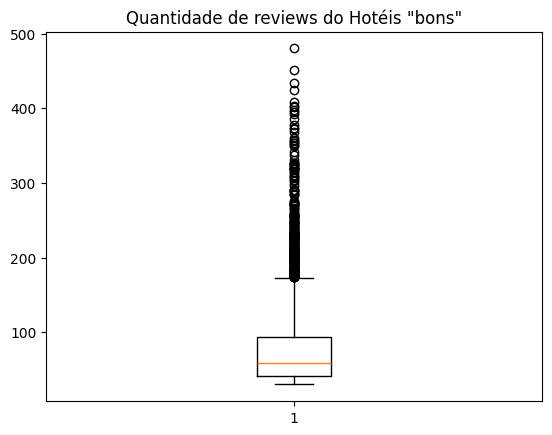

,name,price,minimum_nights,reviews_count,yearly_availability
5,BlissArtsSpace!,60,45,49,0
7,Cozy Clean Guest Room - Family Apt,79,2,118,0
9,Beautiful 1br on Upper West Side,135,5,53,6
10,Central Manhattan/near Broadway,85,2,188,39
14,Only 2 stops to Manhattan studio,140,2,148,46
...,...,...,...,...,...
42664,Queens Studio.,55,2,37,6
42941,Lucio's Room #3 a unos minutos del JFK y LGA,75,1,31,89
43138,Comfortable Room with Private Bath - 15 min to...,50,1,34,61
43790,NYC High End Upper East Side Central Park Gem ...,151,1,30,42


In [270]:
# mínimo e média  da reviews_count. O mínimo aponta se há erro na inserção, caso haja valor negativo.
minimo_numero_reviews = data_frame['reviews_count'].min()
media_numero_reviews = data_frame['reviews_count'].mean()

# média de disponibilidade anual 
media_disponibilidade = data_frame['yearly_availability'].mean()
print(f'Quantidade mínima de reviews: {minimo_numero_reviews}\nMédia do número de reviews: {media_numero_reviews:.2f}\nMédia de disponibilidade anual: {media_disponibilidade:.2f}')

df_disponibilidade_abaixo_media = data_frame[data_frame['yearly_availability'] < media_disponibilidade]

df_lugares_bons_de_alugar = df_disponibilidade_abaixo_media[df_disponibilidade_abaixo_media['reviews_count'] > media_numero_reviews]
df_lugares_bons_de_alugar = df_lugares_bons_de_alugar[['name','price','minimum_nights','reviews_count','yearly_availability']]

# identificando outliers
df = outliers_identification(df_lugares_bons_de_alugar,'reviews_count')
quantidade_de_outliers_superior = df['superior_outliers'].shape[0]
quantidade_total_de_dados = df_lugares_bons_de_alugar['reviews_count'].shape[0]
percentual_de_outliers_superior = (quantidade_de_outliers_superior/quantidade_total_de_dados)*100
print(f'Percentual de outliers superior: {percentual_de_outliers_superior:.2f}%')

plt.boxplot(df_lugares_bons_de_alugar['reviews_count'])
plt.title('Quantidade de reviews do Hotéis "bons"')
plt.show()

df_lugares_bons_de_alugar

# 5.2 Hipóteses e Validações sobre Preços e Distritos

**Hipótese Inicial:**  
Após visualizar os dados deste DataFrame, surgiu-me uma hipótese: os distritos mais populosos de Nova York são os mais baratos para se alugar. Para validar essa ideia, realizei uma breve pesquisa na Internet sobre as populações desses distritos entre os anos de 2011 e 2019. Escolhi essas datas porque a coluna de datas do dataset varia de **2011-03-28** (a menor data) a **2019-07-08** (a maior data).

### População dos Distritos de Nova York (2011–2019)

| Ano   | Manhattan   | Brooklyn    | Queens      | Bronx       | Staten Island |
|-------|-------------|-------------|-------------|-------------|---------------|
| 2011  | 1.605.000   | 2.565.000   | 2.275.000   | 1.395.000   | 470.000       |
| 2012  | 1.630.000   | 2.580.000   | 2.490.000   | 1.496.000   | 475.000       |
| 2013  | 1.635.000   | 2.595.000   | 2.305.000   | 1.415.000   | 480.000       |
| 2014  | 1.650.000   | 2.610.000   | 2.320.000   | 1.425.000   | 485.000       |
| 2015  | 1.465.000   | 2.625.000   | 2.335.000   | 1.453.000   | 490.000       |
| 2016  | 1.680.000   | 2.640.000   | 2.350.000   | 1.445.000   | 495.000       |
| 2017  | 1.695.000   | 2.655.000   | 2.365.000   | 1.455.000   | 500.000       |
| 2018  | 1.710.000   | 2.670.000   | 2.390.000   | 1.465.000   | 505.000       |
| 2019  | 1.725.000   | 2.685.000   | 2.295.000   | 1.475.000   | 510.000       |

**Observação:**  
Apesar das oscilações nas populações ao longo dos anos, um fato persiste: **Brooklyn** é o distrito mais populoso, enquanto **Staten Island** é o menos populoso.

---

## Primeira Validação

**Objetivo:**  
Testar se a hipótese inicial está correta. Para isso, calculei a média dos preços das diárias e agrupei-os por distrito. Em seguida, criei um gráfico de barras com os distritos no eixo X e a média dos preços no eixo Y.

### Média dos Preços por Distrito

| Distrito       | Diária Média  | Ranqueamento |
|----------------|---------------|--------------|
| Bronx          | 79.558857     | 5            |
| Brooklyn       | 121.461613    | 2            |
| Manhattan      | 180.071596    | 1            |
| Queens         | 95.783683     | 3            |
| Staten Island  | 89.964968     | 4            |

**Conclusão:**  
Manhattan é o distrito mais caro, enquanto o Bronx é o mais barato. Portanto, a hipótese inicial estava **incorreta**.

---

## Segunda Hipótese

**Nova Hipótese:**  
O ranqueamento de preços se mantém quando consideramos o "preço real" (preço da diária multiplicado pelo número mínimo de noites necessárias). Para testar essa ideia, recalculei as médias utilizando o preço real.

### Preço Real Médio por Distrito

| Distrito       | Preço Real Médio | Ranqueamento |
|----------------|------------------|--------------|
| Bronx          | 289.017143       | 5            |
| Brooklyn       | 653.465872       | 2            |
| Manhattan      | 1328.286746      | 1            |
| Queens         | 579.924541       | 3            |
| Staten Island  | 311.729299       | 4            |

**Conclusão:**  
Manhattan continua sendo o distrito mais caro, e o Bronx permanece como o mais barato. O ranqueamento **não mudou** em relação à primeira validação.

---

## Análise do Crescimento Percentual

**Objetivo:**  
Calcular o aumento percentual médio do preço real em relação ao preço da diária para cada distrito.

### Crescimento Percentual por Distrito

| Distrito       | Crescimento Percentual (%) | Ranqueamento |
|----------------|----------------------------|--------------|
| Bronx          | 363.274629                 | 4            |
| Brooklyn       | 538.001969                 | 3            |
| Manhattan      | 737.643678                 | 1            |
| Queens         | 605.452328                 | 2            |
| Staten Island  | 346.500761                 | 5            |

**Conclusão Final:**  
Embora Manhattan tenha mantido sua posição como o distrito mais caro, o ranqueamento dos demais distritos mudou. O crescimento percentual revelou que **Manhattan** tem o maior aumento, seguido por **Queens**, **Brooklyn**, **Bronx** e **Staten Island**.

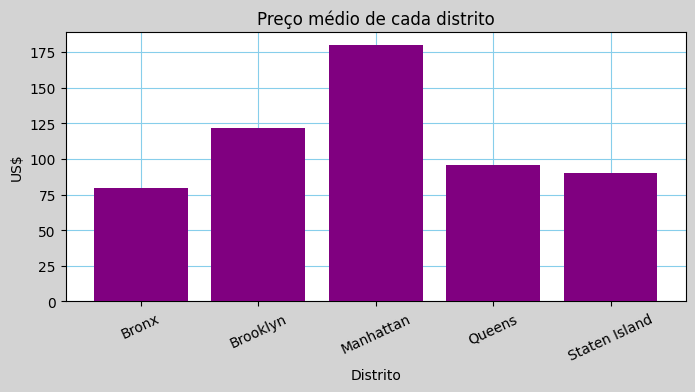

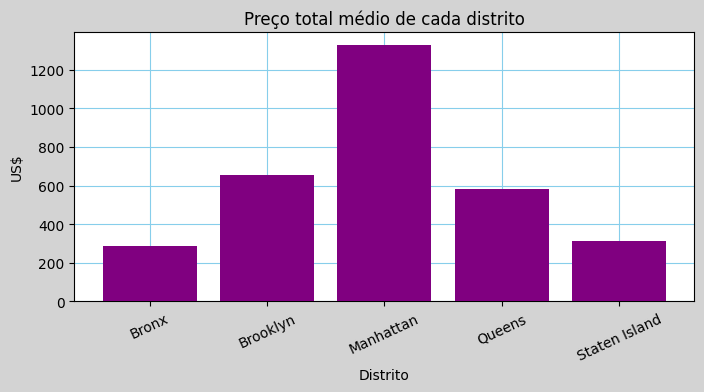

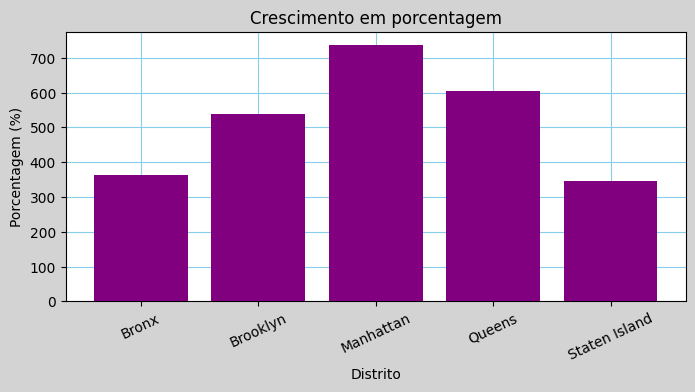

In [271]:
# calcular preço médio da diária e agrupar por distrito
df_preco_medio_por_distrito = data_frame.groupby('district')['price'].mean()

# chamada da função para a plotagem do gráfico de barras com as especificações do canvas
plot_bar_specific(df_preco_medio_por_distrito, 'Distrito', 'US$', 'Preço médio de cada distrito')

# calcular preço total médio e agrupar por distrito
df_preco_total_medio_por_distrito = data_frame.groupby('district')['total_price'].mean()

# chamada da função para a plotagem do gráfico de barras com as especificações do canvas
plot_bar_specific(df_preco_total_medio_por_distrito, 'Distrito', 'US$', 'Preço total médio de cada distrito')

# valores das médias armazenadas em arrays para calcular o crescimento percentual entre as duas
medias_por_distrito = df_preco_medio_por_distrito.values
medias_reais_por_distrito = df_preco_total_medio_por_distrito.values

# cálculo do percentual de crescimento preço_total/preço_diaria
for i in range(len(medias_reais_por_distrito)):
    percentual_crescimento = (medias_reais_por_distrito/medias_por_distrito)*100
# chamda da função para o caso específico com a utilização de kwargs
plot_bar_specific(df_preco_total_medio_por_distrito, 'Distrito', 'Porcentagem (%)', 'Crescimento em porcentagem', values=percentual_crescimento)

# 5.3 Análise de Disponibilidade e Preço por Tipo de Acomodação e Ano
### Tipos de Acomodação

Existem três tipos principais de acomodação disponíveis:
- **Entire home/apt**: Residência ou apartamento inteiro.
- **Private room**: Quarto privativo.
- **Shared room**: Quarto compartilhado.

### Hipótese

A hipótese inicial é que os quartos compartilhados (**Shared room**) são, em média, os mais disponíveis e baratos para alugar. Essa suposição é baseada na ideia de que compartilhar um cômodo pode ser desconfortável para muitos clientes, tornando esse tipo de acomodação o menos procurado.

### Análise de Dados

- **Disponibilidade:** Por serem menos populares, os cômodos compartilhados devem apresentar maior disponibilidade anual.
- **Preço:** Espera-se que o preço médio dos quartos compartilhados seja menor em comparação com os outros tipos de acomodação.

### Limitação dos Dados

A quantidade de registros relacionados a **Shared room** é significativamente menor do que as categorias **Entire home/apt** e **Private room**. Devido a essa limitação, a análise de faturamento anual será restrita às categorias **Entire home/apt** e **Private room**.

### Conclusão

A análise de preços e disponibilidade para as categorias mais representativas (**Entire home/apt** e **Private room**) fornecerá insights mais robustos e confiáveis sobre o faturamento anual, descartando possíveis vieses causados pela baixa quantidade de dados de **Shared room**.


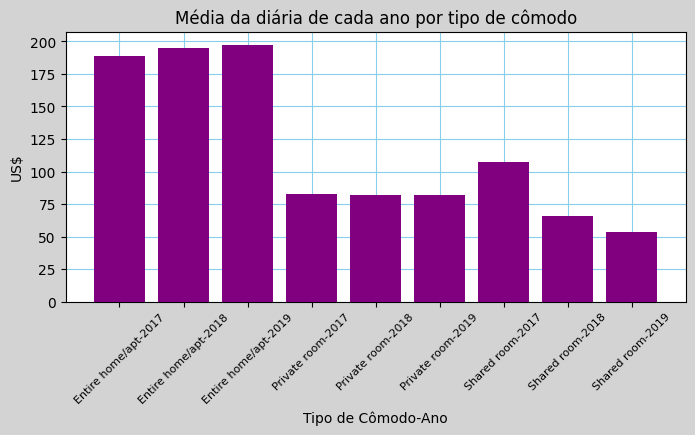

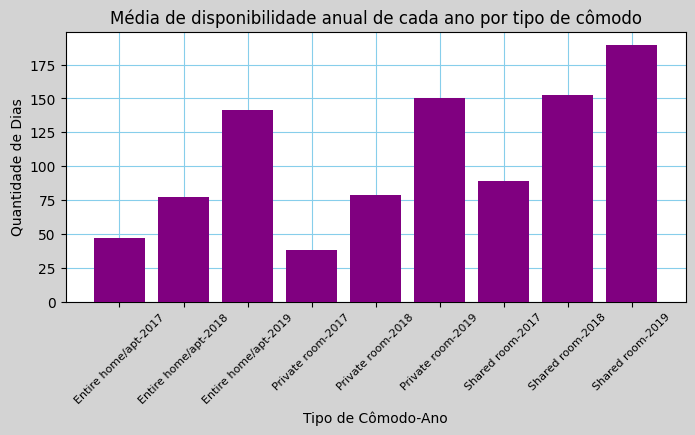

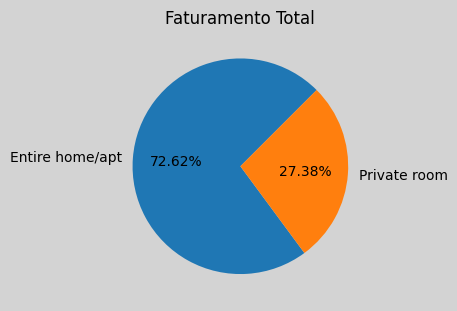

In [272]:
# seleção dos anos acima de 2016 (2017-2019)
df_anos_selecionados = data_frame[data_frame['year'] > 2016]

# data frame contendo média de disponibilidade anual para cada tipo de cômodo e ano
disponibilidade_media_por_room_type = df_anos_selecionados.groupby(['room_type', 'year'])['yearly_availability'].mean()

# data frame contendo média de preço de diária para cada tipo de cômodo e ano
preco_medio_por_room_type = df_anos_selecionados.groupby(['room_type', 'year'])['price'].mean()

# array contendo as categorias concatenadas (room_type-year)
categorias_room_type_by_year = categories_appender(disponibilidade_media_por_room_type)

# chamdas da função utilizando as categorias coletadas acima
plot_bar_specific(preco_medio_por_room_type, 'Tipo de Cômodo-Ano', 'US$', 'Média da diária de cada ano por tipo de cômodo', categorias=categorias_room_type_by_year)
plot_bar_specific(disponibilidade_media_por_room_type, 'Tipo de Cômodo-Ano', 'Quantidade de Dias', 'Média de disponibilidade anual de cada ano por tipo de cômodo', categorias=categorias_room_type_by_year)

# copia do data_frame original para fazer execuções sobre ele
df_copy = data_frame.copy()

# eliminação das linhas com 'Shared room'
df_copy = df_copy[df_copy['room_type'] != 'Shared room']

# criação de nova tabela na cópia do data frame original
df_copy['annual_revenue'] = df_copy.apply(lambda row: row['price']*row['booked_days'],axis=1)

# execução da soma dos faturamentos de cada ano agrupados por room_type
df_faturamento_anual_por_room_type = df_copy.groupby('room_type')['annual_revenue'].sum().reset_index()

# plot de um gráfico de setores
plt.figure(figsize=(8,3.5), facecolor = 'lightgrey')
plt.pie(df_faturamento_anual_por_room_type['annual_revenue'], labels=df_faturamento_anual_por_room_type['room_type'], autopct='%1.2f%%',startangle=45)
plt.title('Faturamento Total')
plt.show()

# 6.0 Previsão do Preço a partir dos dados
Previsão da diária e não do tolta_price

## Preparação dos dados

### Atribuição de variáveis

In [273]:
# cópia do data frame original
df = data_frame.copy()

# remoção da coluna price e total_price
X = df.drop(['price', 'total_price'], axis=1)

# series com a coluna price
y = df['price']

# remoção da tabela total_price
X_sem_outliers = df.drop('total_price', axis=1)

### Pré processamento

In [274]:
# pré processamento dos dados para predição
X = pre_processing_prediction(X)
X_sem_outliers = pre_processing_prediction(X_sem_outliers, sem_outliers=True)

C:\Users\gugui\AppData\Local\Temp\ipykernel_19068\3940833697.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price'] = s


### atribuição da base sem os outliers

In [275]:
# series com a coluna prices após remoção das linhas de outliers
y_sem_outliers = X_sem_outliers['price']

# remoção da coluna price da base de dados
X_sem_outliers = X_sem_outliers.drop('price', axis=1)

### Codificar colunas da base de dados

In [276]:
X = encoding(X)
X_sem_outliers = encoding(X_sem_outliers)

### slip dos dados em treino e teste

In [277]:
# divisao dos dados para treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20, random_state=26) 

# divisão dos dados para treino e teste (sem outliers)
X_treino_s, X_teste_s, y_treino_s, y_teste_s = train_test_split(X_sem_outliers, y_sem_outliers, test_size=0.20, random_state=26) 


## treinamento e predição dos modelos

In [278]:
modelos = {
    'Regressão-Linear' : LinearRegression(),
    'Lasso' : Lasso(alpha=0.1),
    'Huber-Regressor' : HuberRegressor(max_iter=2000),
    'Random-Forest-Regressor' : RandomForestRegressor(random_state=26, n_estimators=50,max_depth=5),
    'Ridge' : Ridge(alpha=1.0),
    'ElasticNet' : ElasticNet(alpha=0.1, l1_ratio=0.5)
}

dir_path = os.path.dirname(os.path.abspath(''))

for nome, modelo in modelos.items():
    modelo.fit(X_treino, y_treino)
    y_pred = modelo.predict(X_teste)
    print(f'Métricas para {nome}:')
    metrics(y_teste, y_pred, y_treino, X_treino)
    print()
    arquivo = nome+'.pkl'
    pickle_path = os.path.join(dir_path,'Pickle',arquivo)
    with open(pickle_path, 'wb') as f:
        pickle.dump(modelo, f)

for nome, modelo in modelos.items():
    modelo.fit(X_treino_s, y_treino_s)
    y_pred_s = modelo.predict(X_teste_s)
    print(f'Métricas para {nome}:')
    metrics(y_teste_s, y_pred_s, y_treino_s, X_treino_s)
    print()
    arquivo = nome+'sem_outliers.pkl'
    pickle_path = os.path.join(dir_path,'Pickle',arquivo)
    with open(pickle_path, 'wb') as f:
        pickle.dump(modelo, f)


Métricas para Regressão-Linear:
MAE: 62.60753286142062
RMSE: 182.72013118470008
R²: 0.10193415446277054
R² treino: 0.1107863312322791
MAPE: 51.93%



C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e+08, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


Métricas para Lasso:
MAE: 62.39843878532564
RMSE: 182.56170877213276
R²: 0.10349076543626323
R² treino: 0.110395723694665
MAPE: 51.64%

Métricas para Huber-Regressor:
MAE: 83.45182793059334
RMSE: 202.70610880589055
R²: -0.10527171735666041
R² treino: -0.09655953450992527
MAPE: 62.33%

Métricas para Random-Forest-Regressor:
MAE: 57.21903035505373
RMSE: 171.85122247019459
R²: 0.20559744011443282
R² treino: 0.38040686574437954
MAPE: 43.65%

Métricas para Ridge:
MAE: 62.57758244214905
RMSE: 182.7122691854531
R²: 0.10201143594298367
R² treino: 0.11078214462932978
MAPE: 51.88%



C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.89356e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.803e+08, tolerance: 1.218e+05
  model = cd_fast.enet_coordinate_descent(


Métricas para ElasticNet:
MAE: 64.39530696290905
RMSE: 183.76341887828522
R²: 0.09164939939168715
R² treino: 0.09458005450971463
MAPE: 55.31%

Métricas para Regressão-Linear:
MAE: 61.494569063711396
RMSE: 147.87645494652972
R²: 0.17771612049826613
R² treino: 0.1394290863118609
MAPE: 50.25%



C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.606e+08, tolerance: 6.188e+04
  model = cd_fast.enet_coordinate_descent(


Métricas para Lasso:
MAE: 61.26010391867133
RMSE: 147.9496153491326
R²: 0.17690228571789057
R² treino: 0.1389153641363201
MAPE: 49.92%

Métricas para Huber-Regressor:
MAE: 90.69526189572792
RMSE: 179.21916943959832
R²: -0.20779335406476296
R² treino: -0.18025724514820585
MAPE: 66.22%

Métricas para Random-Forest-Regressor:
MAE: 56.76963103725603
RMSE: 153.73843595921275
R²: 0.11123154480841801
R² treino: 0.39404678121537773
MAPE: 42.46%

Métricas para Ridge:
MAE: 61.463645817222556
RMSE: 147.88614420179712
R²: 0.1776083605518498
R² treino: 0.13941662999974502
MAPE: 50.19%



C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.84313e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Métricas para ElasticNet:
MAE: 63.71480675961719
RMSE: 150.35145066901288
R²: 0.14996078724733086
R² treino: 0.1202283121166905
MAPE: 53.79%



C:\Users\gugui\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+08, tolerance: 6.188e+04
  model = cd_fast.enet_coordinate_descent(


## Interpretação das métricas

## Questão 4

In [279]:
xp = pd.DataFrame([{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}])

xp = func_question_4(xp)
for coluna in xp.select_dtypes(include=['object', 'datetime64[ns]', 'bool']).columns:
    xp[coluna] = encoder.fit_transform(xp[coluna])
modelo = RandomForestRegressor(random_state=26, n_estimators=50,max_depth=5).fit(X_treino, y_treino)
xp = xp.drop(['year','is_leap_year'],axis=1)
yp = modelo.predict(xp)
print(yp)

[442.27433497]


## função utilizada na questão 4

In [280]:
def func_question_4(df):
    """
        função que prepara a base de dados para a análise. Sua função é padronizar e renomear colunas,
         remover valores vazios do dataset, transformação de dados e criação de outras colunas que auxiliam
         na análise dos dados.
         args:
             df (Pandas.DataFrame): data frame ao qual será realizado todo o processamento de dados.
    """
    # padronização dos nomes das colunas
    # criação de um dict com a troca de nomes das colunas
    colunas_renomeadas = {'nome':'name',
                          'bairro_group':'district',
                          'bairro':'neighborhood',
                          'minimo_noites':'minimum_nights',
                          'numero_de_reviews':'reviews_count',
                          'ultima_review':'last_review',
                          'reviews_por_mes':'monthly_reviews',
                          'calculado_host_listings_count':'calculated_host_listings_count',
                          'disponibilidade_365':'yearly_availability'}
    
    df.rename(columns=colunas_renomeadas, inplace=True)
    
    # eliminação de valores vazios das colunas identificadas
    for coluna in ['name', 'host_name', 'last_review', 'monthly_reviews']:
        df.dropna(subset=[coluna], inplace=True)
    
    # transformar coluna last_review em date time
    df['last_review'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')
    
    # criação da coluna year contendo somente o ano da coluna last_review
    df['year'] = df['last_review'].dt.year
    df['year'] = np.int64(df['year'])
    
    # criação da coluna is_leap_year para checar se o ano é bissexto ou não
    df['is_leap_year'] = df['year'].apply(is_leap_year)
    
    # criação da coluna days booked_days informando quantos dias já foram agendados naquele ano
    df['booked_days'] = df.apply(
                            lambda row: 366 - row['yearly_availability'] if is_leap_year(row['year']) else 365 - row['yearly_availability'],
                            axis = 1
                        )
    return df